In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from thirdparty.fem_2d_rec import fem_poisson_solver,mesh_fem_2d_rec,get_matrices_2d
from common.util import create_boundary_mask, create_interior_mask, Dirichlet_bc_tensor, Dirichlet_bc_array
from models.autoencoder import Autoencoder

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Step 0: Generate FEM solutions

In [4]:
def generate_fem_u_matrices(f_values, input_shape, u_file_name, f_file_name):
    a, b, k, M = 0, 1, 1, 255
    c4n, n4e, n4db, ind4e = mesh_fem_2d_rec(a, b, a, b, M, M, k)
    M_R, Srr_R, Sss_R, Dr_R, Ds_R = get_matrices_2d(k)
    f_matrices = []
    u_matrices = []

    for f_value in tqdm(f_values, desc="Generating FEM solutions"):
        f = lambda x: np.full(x.shape[0], f_value)
        u_D = lambda x: x[:, 0] * 0
        fem_u = fem_poisson_solver(c4n, n4e, n4db, ind4e, k, M_R, Srr_R, Sss_R, f, u_D)
        fem_u_reshaped = fem_u.reshape(input_shape)
        f_matrix = np.full(input_shape, f_value)
        # f_matrix = Dirichlet_bc_array(f_matrix)
        u_matrices.append(fem_u_reshaped)
        f_matrices.append(f_matrix)

    u_matrices = np.array(u_matrices)
    f_matrices = np.array(f_matrices)
    np.save(u_file_name, u_matrices)
    np.save(f_file_name, f_matrices)
    print(f"Saved {len(u_matrices)} u matrices to {u_file_name}")
    print(f"Saved {len(f_matrices)} f matrices to {f_file_name}")
    return u_matrices, f_matrices

In [5]:
f_values = np.arange(-5000, 5000, 2)
input_shape = (256, 256)
u_file_name = './u_dataset.npy'
f_file_name = './f_dataset.npy'
u_matrices, f_matrices = generate_fem_u_matrices(f_values, input_shape, u_file_name, f_file_name)
print(f"Generated {len(u_matrices)} u matrices and f matrices")

Generating FEM solutions:   0%|          | 0/5000 [00:00<?, ?it/s]

Generating FEM solutions: 100%|██████████| 5000/5000 [1:13:14<00:00,  1.14it/s]


Saved 5000 u matrices to ./u_dataset.npy
Saved 5000 f matrices to ./f_dataset.npy
Generated 5000 u matrices and f matrices


# Step 1: VAE Model

In [28]:
class PoissonDataset(Dataset):
    def __init__(self, u_matrices):
        self.u_matrices = u_matrices

    def __len__(self):
        return len(self.u_matrices)

    def __getitem__(self, idx):
        u_matrix = self.u_matrices[idx]
        u_tensor = torch.tensor(u_matrix).unsqueeze(0).float()  # (1, H, W) 형태로 변환
        return u_tensor

u_matrices = np.load(f'./{u_file_name}')
dataset = PoissonDataset(u_matrices)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [29]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 512),
            nn.ReLU()
        )
        
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)
        
        self.fc_dec = nn.Linear(latent_dim, 512)
        
        self.decoder = nn.Sequential(
            nn.Linear(512, 128 * 32 * 32),
            nn.ReLU(),
            nn.Unflatten(1, (128, 32, 32)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.fc_dec(z)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar, z

In [30]:
def he_weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [31]:
def vae_loss(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

  1%|          | 1/100 [00:08<13:18,  8.06s/it]

Epoch 1, Loss: 792515836023.4121


  2%|▏         | 2/100 [00:16<13:12,  8.08s/it]

Epoch 2, Loss: 13914433732.29393


  3%|▎         | 3/100 [00:24<13:07,  8.11s/it]

Epoch 3, Loss: 13086827446.389776


  4%|▍         | 4/100 [00:32<13:01,  8.14s/it]

Epoch 4, Loss: 12462400606.875399


  5%|▌         | 5/100 [00:40<12:52,  8.13s/it]

Epoch 5, Loss: 11829873597.7508


  6%|▌         | 6/100 [00:48<12:44,  8.13s/it]

Epoch 6, Loss: 11263383817.814697


  7%|▋         | 7/100 [00:56<12:35,  8.12s/it]

Epoch 7, Loss: 10728679626.83706


  8%|▊         | 8/100 [01:05<12:29,  8.15s/it]

Epoch 8, Loss: 10377156830.466454


  9%|▉         | 9/100 [01:13<12:23,  8.17s/it]

Epoch 9, Loss: 9813489821.035143
Epoch 10, Loss: 9342761937.380192


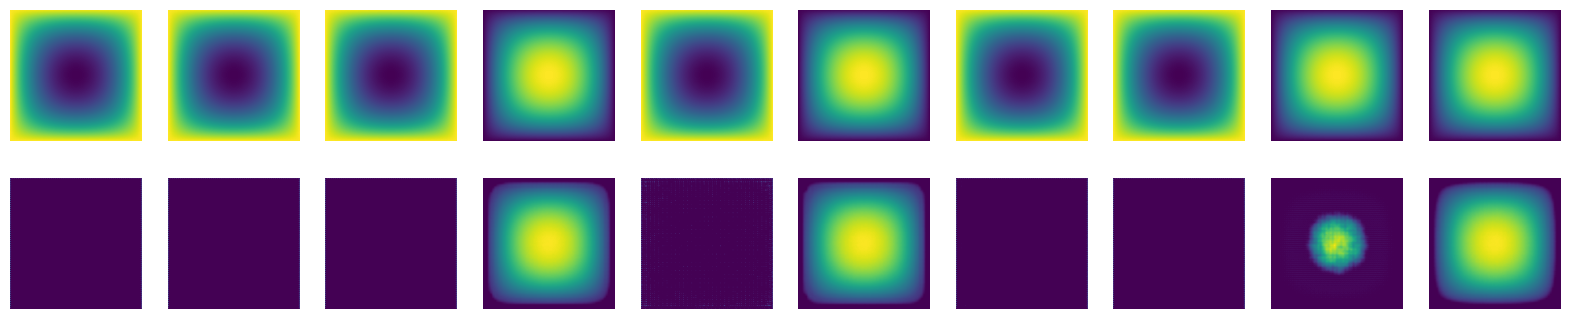

 11%|█         | 11/100 [01:29<12:09,  8.19s/it]

Epoch 11, Loss: 8934355310.824282


 12%|█▏        | 12/100 [01:37<11:58,  8.16s/it]

Epoch 12, Loss: 8656986401.942492


 13%|█▎        | 13/100 [01:45<11:45,  8.11s/it]

Epoch 13, Loss: 8391597338.58147


 14%|█▍        | 14/100 [01:53<11:34,  8.08s/it]

Epoch 14, Loss: 8174297759.079872


 15%|█▌        | 15/100 [02:01<11:27,  8.09s/it]

Epoch 15, Loss: 8016478565.8274765


 16%|█▌        | 16/100 [02:09<11:17,  8.06s/it]

Epoch 16, Loss: 7909029197.69968


 17%|█▋        | 17/100 [02:18<11:09,  8.07s/it]

Epoch 17, Loss: 7841329035.859425


 18%|█▊        | 18/100 [02:26<11:02,  8.07s/it]

Epoch 18, Loss: 7813626625.022365


 19%|█▉        | 19/100 [02:34<10:52,  8.06s/it]

Epoch 19, Loss: 7758112508.932907
Epoch 20, Loss: 7772057130.939297


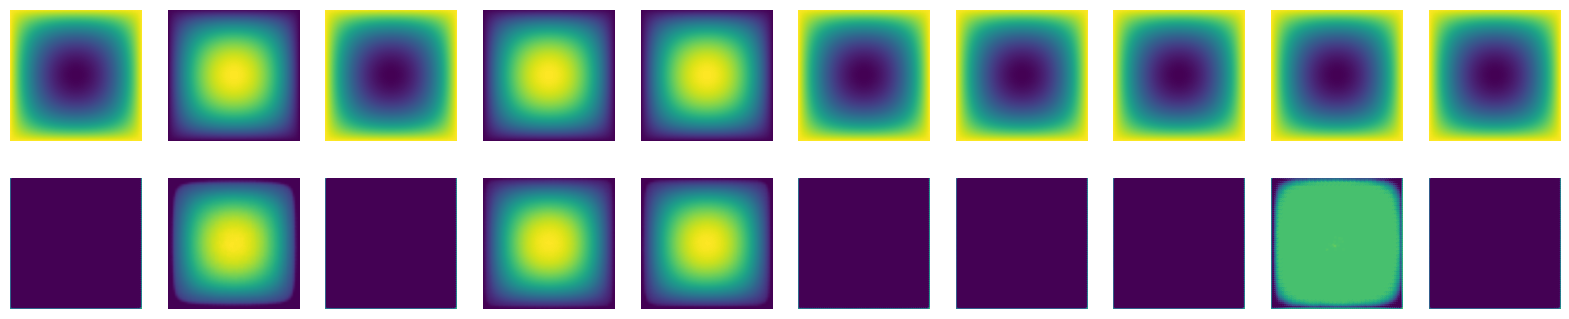

 21%|██        | 21/100 [02:50<10:41,  8.12s/it]

Epoch 21, Loss: 7736923944.485623


 22%|██▏       | 22/100 [02:58<10:30,  8.09s/it]

Epoch 22, Loss: 7755730617.661342


 23%|██▎       | 23/100 [03:06<10:22,  8.09s/it]

Epoch 23, Loss: 7731956639.897763


 24%|██▍       | 24/100 [03:14<10:15,  8.10s/it]

Epoch 24, Loss: 7786977861.520767


 25%|██▌       | 25/100 [03:22<10:06,  8.09s/it]

Epoch 25, Loss: 7780353758.466454


 26%|██▌       | 26/100 [03:30<09:58,  8.09s/it]

Epoch 26, Loss: 7690335005.035144


 27%|██▋       | 27/100 [03:39<09:52,  8.11s/it]

Epoch 27, Loss: 7672427383.003195


 28%|██▊       | 28/100 [03:47<09:42,  8.10s/it]

Epoch 28, Loss: 7669008687.846645


 29%|██▉       | 29/100 [03:55<09:35,  8.11s/it]

Epoch 29, Loss: 7656426573.290735
Epoch 30, Loss: 7642676258.351438


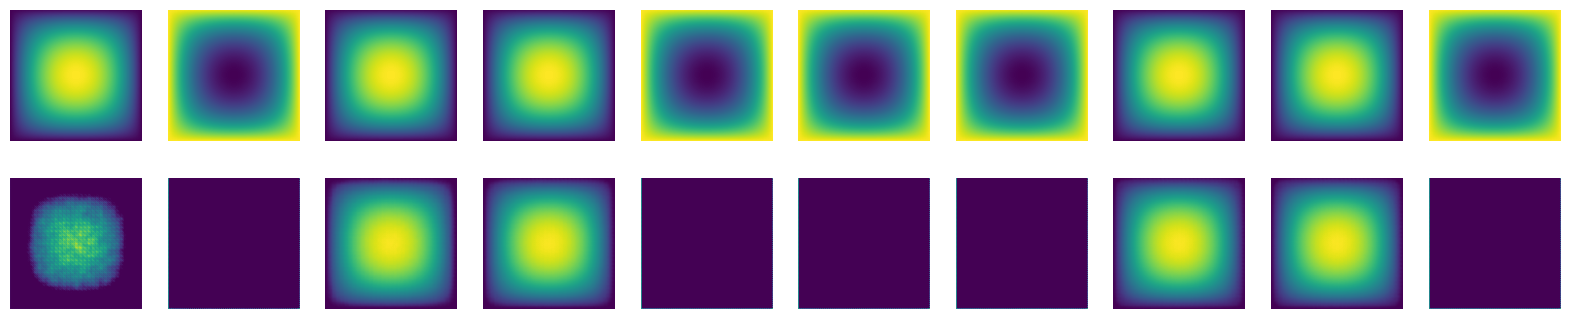

 31%|███       | 31/100 [04:12<09:29,  8.25s/it]

Epoch 31, Loss: 7632564015.846645


 32%|███▏      | 32/100 [04:20<09:20,  8.24s/it]

Epoch 32, Loss: 7624499944.690096


 33%|███▎      | 33/100 [04:28<09:08,  8.18s/it]

Epoch 33, Loss: 7590478142.977635


 34%|███▍      | 34/100 [04:36<08:55,  8.11s/it]

Epoch 34, Loss: 7543110734.824281


 35%|███▌      | 35/100 [04:44<08:45,  8.09s/it]

Epoch 35, Loss: 7595762112.204473


 36%|███▌      | 36/100 [04:52<08:38,  8.10s/it]

Epoch 36, Loss: 7568730699.246006


 37%|███▋      | 37/100 [05:00<08:31,  8.11s/it]

Epoch 37, Loss: 7521445032.894568


 38%|███▊      | 38/100 [05:08<08:23,  8.12s/it]

Epoch 38, Loss: 7553996118.2875395


 39%|███▉      | 39/100 [05:16<08:12,  8.07s/it]

Epoch 39, Loss: 7523605443.680511
Epoch 40, Loss: 7532441510.440894


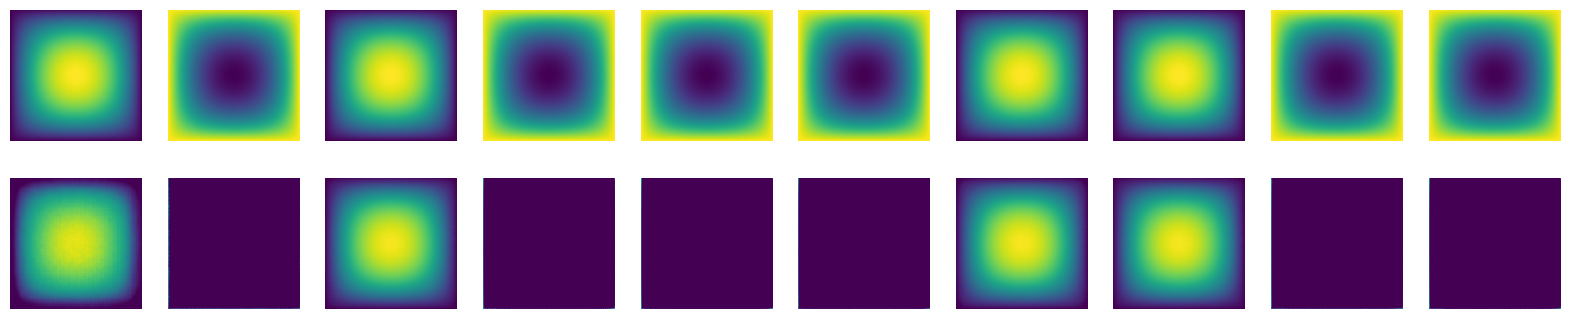

 41%|████      | 41/100 [05:33<08:02,  8.17s/it]

Epoch 41, Loss: 7525502467.271565


 42%|████▏     | 42/100 [05:41<07:53,  8.17s/it]

Epoch 42, Loss: 7516399010.55591


 43%|████▎     | 43/100 [05:49<07:43,  8.13s/it]

Epoch 43, Loss: 7560941486.824281


 44%|████▍     | 44/100 [05:57<07:32,  8.09s/it]

Epoch 44, Loss: 7520854612.85623


 45%|████▌     | 45/100 [06:05<07:24,  8.09s/it]

Epoch 45, Loss: 7514610249.201278


 46%|████▌     | 46/100 [06:13<07:15,  8.07s/it]

Epoch 46, Loss: 7501309643.654952


 47%|████▋     | 47/100 [06:21<07:10,  8.13s/it]

Epoch 47, Loss: 7509479599.13099


 48%|████▊     | 48/100 [06:30<07:04,  8.17s/it]

Epoch 48, Loss: 7493024718.108626


 49%|████▉     | 49/100 [06:38<06:58,  8.21s/it]

Epoch 49, Loss: 7478183681.022365
Epoch 50, Loss: 7501962056.996805


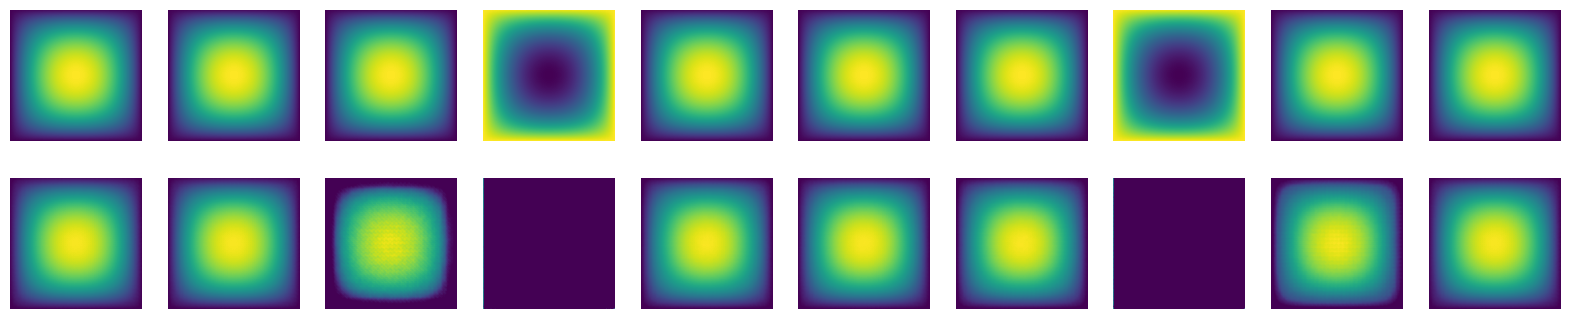

 51%|█████     | 51/100 [06:54<06:43,  8.23s/it]

Epoch 51, Loss: 7493676307.015974


 52%|█████▏    | 52/100 [07:03<06:34,  8.23s/it]

Epoch 52, Loss: 7519193067.348243


 53%|█████▎    | 53/100 [07:11<06:27,  8.25s/it]

Epoch 53, Loss: 7486427840.613419


 54%|█████▍    | 54/100 [07:19<06:15,  8.15s/it]

Epoch 54, Loss: 7487892802.658147


 55%|█████▌    | 55/100 [07:27<06:04,  8.09s/it]

Epoch 55, Loss: 7467696643.680511


 56%|█████▌    | 56/100 [07:35<05:52,  8.01s/it]

Epoch 56, Loss: 7497211188.753994


 57%|█████▋    | 57/100 [07:43<05:43,  7.99s/it]

Epoch 57, Loss: 4.262320462111695e+18


 58%|█████▊    | 58/100 [07:51<05:37,  8.03s/it]

Epoch 58, Loss: 512396050465158.56


 59%|█████▉    | 59/100 [07:59<05:32,  8.10s/it]

Epoch 59, Loss: 337741155068325.2
Epoch 60, Loss: 96698915685372.73


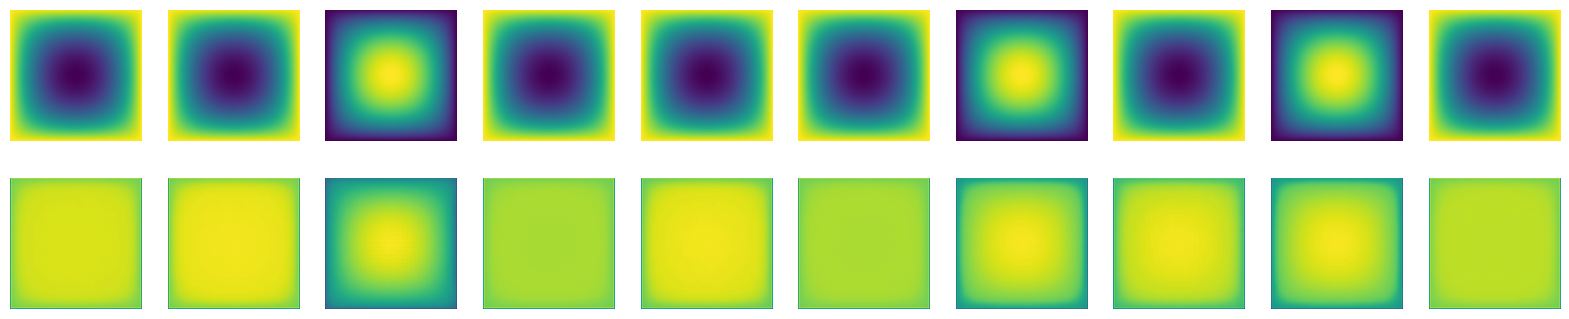

 61%|██████    | 61/100 [08:16<05:19,  8.19s/it]

Epoch 61, Loss: 31731046037484.37


 62%|██████▏   | 62/100 [08:24<05:11,  8.21s/it]

Epoch 62, Loss: 172573104574777.06


 63%|██████▎   | 63/100 [08:32<05:03,  8.21s/it]

Epoch 63, Loss: 21296368073251.99


 64%|██████▍   | 64/100 [08:40<04:56,  8.23s/it]

Epoch 64, Loss: 41697705382295.516


 65%|██████▌   | 65/100 [08:49<04:48,  8.25s/it]

Epoch 65, Loss: 17353943128121.457


 66%|██████▌   | 66/100 [08:57<04:40,  8.25s/it]

Epoch 66, Loss: 18119052939498.43


 67%|██████▋   | 67/100 [09:05<04:31,  8.23s/it]

Epoch 67, Loss: 39265567890450.81


 68%|██████▊   | 68/100 [09:13<04:23,  8.23s/it]

Epoch 68, Loss: 6207151020653.598


 69%|██████▉   | 69/100 [09:22<04:15,  8.25s/it]

Epoch 69, Loss: 16721351242759.77
Epoch 70, Loss: 13291728197747.936


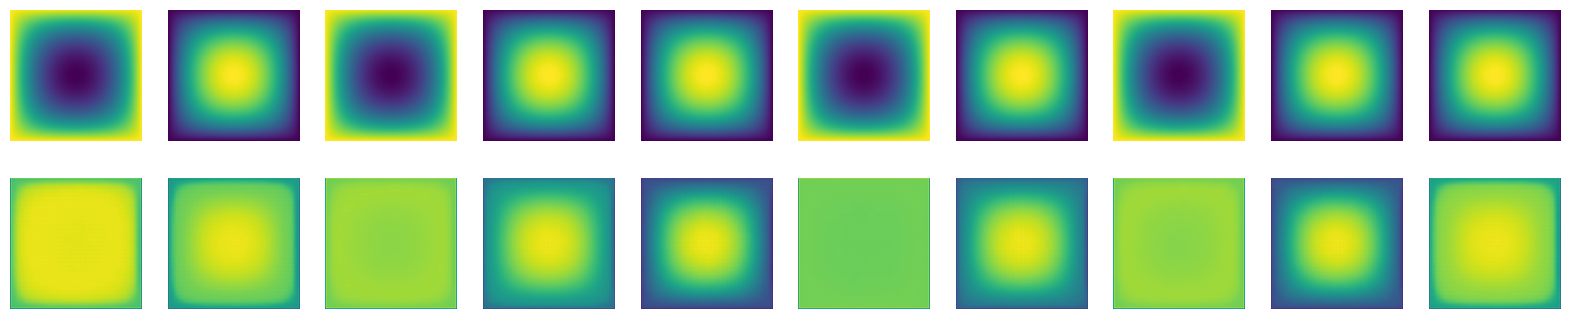

 71%|███████   | 71/100 [09:38<04:00,  8.30s/it]

Epoch 71, Loss: 5208736498428.319


 72%|███████▏  | 72/100 [09:47<03:52,  8.29s/it]

Epoch 72, Loss: 32747682990388.55


 73%|███████▎  | 73/100 [09:55<03:44,  8.31s/it]

Epoch 73, Loss: 3491844025723.9106


 74%|███████▍  | 74/100 [10:03<03:36,  8.32s/it]

Epoch 74, Loss: 3693979003588.0894


 75%|███████▌  | 75/100 [10:12<03:27,  8.28s/it]

Epoch 75, Loss: 8458130390394.4795


 76%|███████▌  | 76/100 [10:20<03:17,  8.23s/it]

Epoch 76, Loss: 3292945181726.8755


 77%|███████▋  | 77/100 [10:28<03:09,  8.23s/it]

Epoch 77, Loss: 3615152302872.23


 78%|███████▊  | 78/100 [10:36<03:00,  8.22s/it]

Epoch 78, Loss: 1143250777564.0127


 79%|███████▉  | 79/100 [10:44<02:53,  8.25s/it]

Epoch 79, Loss: 7546155139817.814
Epoch 80, Loss: 6075436052391.259


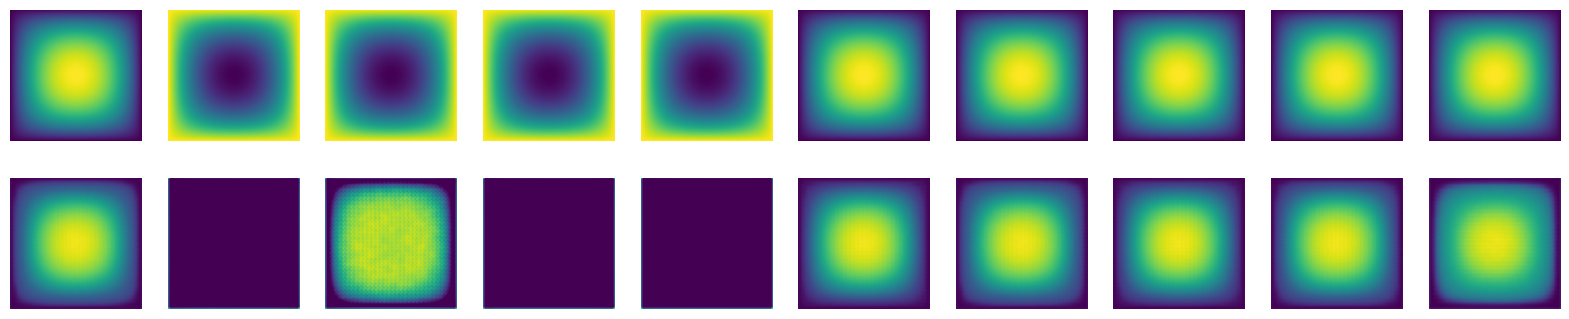

 81%|████████  | 81/100 [11:01<02:37,  8.30s/it]

Epoch 81, Loss: 2479869113824.3066


 82%|████████▏ | 82/100 [11:09<02:29,  8.30s/it]

Epoch 82, Loss: 965579673086.7732


 83%|████████▎ | 83/100 [11:18<02:21,  8.32s/it]

Epoch 83, Loss: 843867804147.7317


 84%|████████▍ | 84/100 [11:26<02:12,  8.29s/it]

Epoch 84, Loss: 627098804212.1406


 85%|████████▌ | 85/100 [11:34<02:04,  8.27s/it]

Epoch 85, Loss: 600618310397.5464


 86%|████████▌ | 86/100 [11:42<01:55,  8.25s/it]

Epoch 86, Loss: 508902122650.5815


 87%|████████▋ | 87/100 [11:51<01:46,  8.23s/it]

Epoch 87, Loss: 155122041843.3227


 88%|████████▊ | 88/100 [11:59<01:38,  8.20s/it]

Epoch 88, Loss: 551602713693.2396


 89%|████████▉ | 89/100 [12:07<01:30,  8.19s/it]

Epoch 89, Loss: 233977913049.96805
Epoch 90, Loss: 185544072539.60382


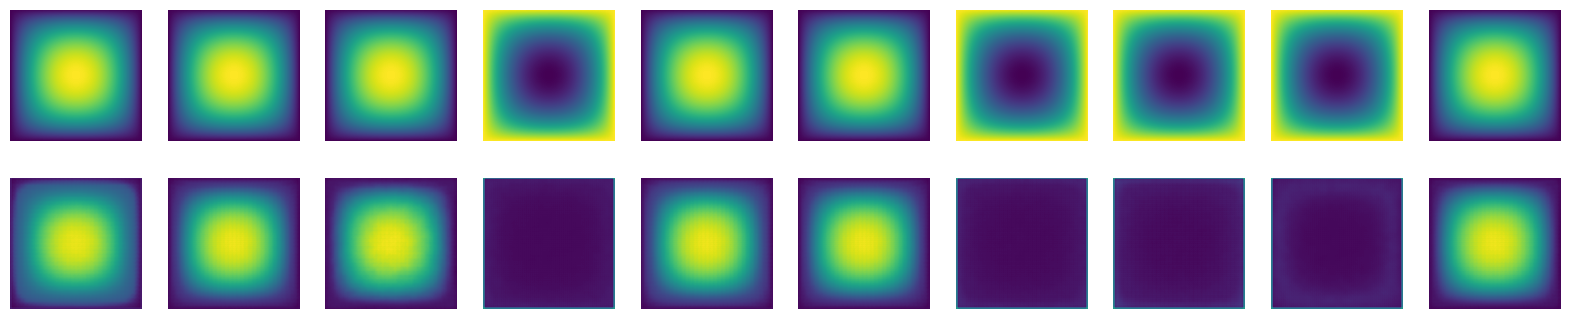

 91%|█████████ | 91/100 [12:24<01:14,  8.24s/it]

Epoch 91, Loss: 559659049986.4536


 92%|█████████▏| 92/100 [12:32<01:05,  8.22s/it]

Epoch 92, Loss: 372486516777.09906


 93%|█████████▎| 93/100 [12:40<00:57,  8.21s/it]

Epoch 93, Loss: 376780568052.34503


 94%|█████████▍| 94/100 [12:48<00:49,  8.21s/it]

Epoch 94, Loss: 273751378477.8019


 95%|█████████▌| 95/100 [12:56<00:40,  8.19s/it]

Epoch 95, Loss: 96290236925.7508


 96%|█████████▌| 96/100 [13:05<00:32,  8.20s/it]

Epoch 96, Loss: 311808596230.54315


 97%|█████████▋| 97/100 [13:13<00:24,  8.20s/it]

Epoch 97, Loss: 198477318190.6198


 98%|█████████▊| 98/100 [13:21<00:16,  8.19s/it]

Epoch 98, Loss: 141347545475.57828


 99%|█████████▉| 99/100 [13:29<00:08,  8.19s/it]

Epoch 99, Loss: 44650846699.14377
Epoch 100, Loss: 50721596265.71246


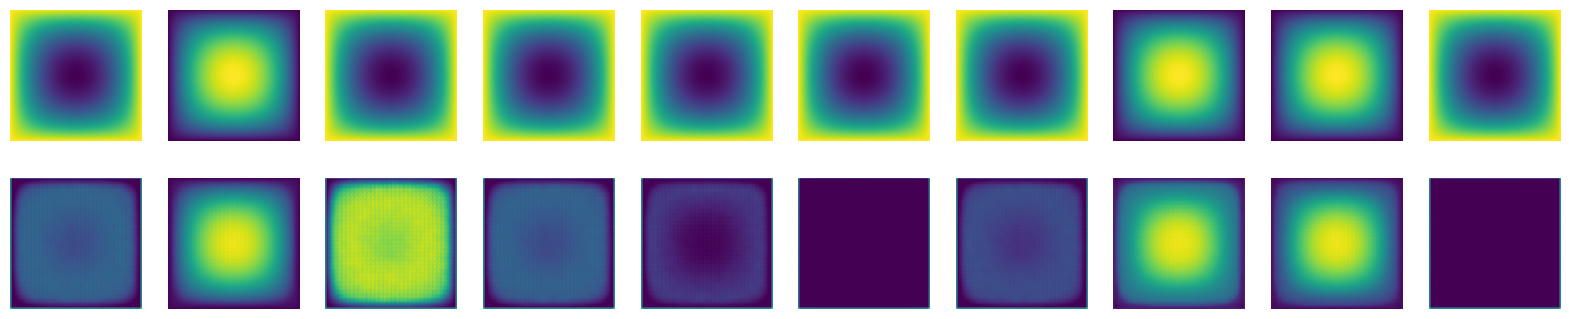

100%|██████████| 100/100 [13:38<00:00,  8.18s/it]


Last Loss: 50721596265.7125 Last vae_model saved to last_vae_model.pth
Best Loss: 7467696643.6805 Best vae_model saved to best_vae_model.pth


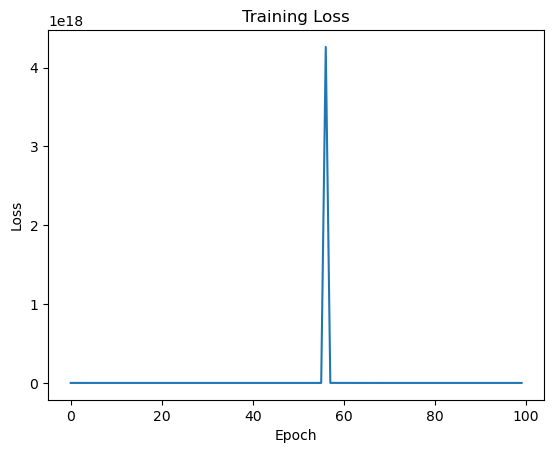

In [33]:
vae_model = VAE(latent_dim=128).to(device)
vae_model.apply(he_weights_init)
optimizer = optim.Adam(vae_model.parameters(), lr=1e-4)

num_epochs = 100
best_loss = float('inf')
train_losses = []
for epoch in tqdm(range(num_epochs)):
    vae_model.train()
    train_loss = 0
    for u_tensor in train_loader:
        u_tensor = u_tensor.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar, z = vae_model(u_tensor)
        loss = vae_loss(recon_x, u_tensor, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Loss: {train_loss}')

    # 10 에폭마다 재구성 이미지 시각화
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            vae_model.eval()
            indices = np.random.choice(len(u_matrices), size=10, replace=False)  # 무작위로 10개의 샘플 선택
            u_tensor = u_matrices[indices]
            u_tensor = torch.tensor(u_tensor).unsqueeze(1).float().to(device)
            recon_x, _, _, _ = vae_model(u_tensor)
            recon_x = recon_x.cpu().numpy()
            
            fig, axes = plt.subplots(2, 10, figsize=(20, 4))
            for i in range(10):
                axes[0, i].imshow(u_tensor[i, 0].cpu(), cmap='viridis')
                axes[0, i].axis('off')
                axes[1, i].imshow(recon_x[i, 0], cmap='viridis')
                axes[1, i].axis('off')
            plt.show()
        vae_model.train()
    
    if train_loss < best_loss:
        best_loss = train_loss
        best_model_wts = vae_model.state_dict()

torch.save(vae_model.state_dict(), 'last_vae_model.pth')
torch.save(best_model_wts, 'best_vae_model.pth')

print(f'Last Loss: {train_loss:.4f} Last vae_model saved to last_vae_model.pth')
print(f'Best Loss: {best_loss:.4f} Best vae_model saved to best_vae_model.pth')

plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Step 2: Latent Space Regression Model

In [ ]:
class LatentSpaceDataset(Dataset):
    def __init__(self, f_matrices, latent_vectors):
        self.f_matrices = f_matrices
        self.latent_vectors = latent_vectors

    def __len__(self):
        return len(self.f_matrices)

    def __getitem__(self, idx):
        f_tensor = torch.tensor(self.f_matrices[idx]).unsqueeze(0).float()  # (1, H, W)
        latent_tensor = torch.tensor(self.latent_vectors[idx]).float()
        return f_tensor, latent_tensor

In [ ]:
class LatentRegressionModel(nn.Module):
    def __init__(self, latent_dim=128):
        super(LatentRegressionModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(64 * 32 * 32, latent_dim)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.ReLU()(self.conv2(x))
        x = nn.ReLU()(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
class PoissonDataset(Dataset):
    def __init__(self, u_matrices):
        self.u_matrices = u_matrices

    def __len__(self):
        return len(self.u_matrices)

    def __getitem__(self, idx):
        u_matrix = self.u_matrices[idx]
        u_tensor = torch.tensor(u_matrix).unsqueeze(0).float()  # (1, H, W) 형태로 변환
        return u_tensor

u_matrices = np.load(f'./{u_file_name}')
dataset = PoissonDataset(u_matrices)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
vae_model.load_state_dict(torch.load('best_vae_model.pth'))
vae_model.eval()

latent_vectors = []
with torch.no_grad():
    for u_tensor in train_loader:
        u_tensor = u_tensor.to(device)
        _, _, _, z = vae_model(u_tensor)
        latent_vectors.append(z.cpu().numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
np.save('latent_vectors.npy', latent_vectors)

In [ ]:
f_matrices = np.load(f'./f_dataset.npy')
latent_vectors = np.load('latent_vectors.npy')

dataset = LatentSpaceDataset(f_matrices, latent_vectors)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
regression_model = LatentRegressionModel(latent_dim=128).to(device)
regression_model.apply(he_weights_init)

optimizer = optim.Adam(regression_model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

num_epochs = 100
best_loss = float('inf')
train_losses = []
for epoch in tqdm(range(num_epochs)):
    regression_model.train()
    train_loss = 0
    for f_tensor, latent_vector in train_loader:
        f_tensor = f_tensor.to(device)
        latent_vector = latent_vector.to(device)
        optimizer.zero_grad()
        predicted_latent = regression_model(f_tensor)
        loss = criterion(predicted_latent, latent_vector)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Loss: {train_loss}')
    
    if train_loss < best_loss:
        best_loss = train_loss
        best_model_wts = regression_model.state_dict()

torch.save(regression_model.state_dict(), 'last_regression_model.pth')
torch.save(best_model_wts, 'best_regression_model.pth')

print(f'Last Loss: {train_loss:.4f} Last regression_model saved to last_regression_model.pth')
print(f'Best Loss: {best_loss:.4f} Best regression_model saved to best_regression_model.pth')

plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Step 3: Inference Model

In [ ]:
class InferenceModel(nn.Module):
    def __init__(self, regression_model, vae_model):
        super(InferenceModel, self).__init__()
        self.regression_model = regression_model
        self.vae_model = vae_model

    def forward(self, f_tensor):
        latent_vector = self.regression_model(f_tensor)
        reconstructed_u = self.vae_model.decode(latent_vector)
        return reconstructed_u

regression_model.load_state_dict(torch.load('best_regression_model.pth'))
regression_model.eval()

vae_model.load_state_dict(torch.load('best_vae_model.pth'))
vae_model.eval()

inference_model = InferenceModel(regression_model, vae_model).to(device)

# Test inference with a new f_matrix
f_value = 10  # example f_value
new_f_matrix = np.full(input_shape, f_value)
new_f_tensor = torch.tensor(new_f_matrix).unsqueeze(0).unsqueeze(0).float().to(device)

with torch.no_grad():
    predicted_u = inference_model(new_f_tensor)

predicted_u = predicted_u.squeeze().cpu().numpy()

plt.imshow(predicted_u, cmap='viridis', extent=(0, 1, 0, 1))
plt.colorbar()
plt.title(f'Predicted u for f={f_value}')
plt.show()
